# Summary

What I demonstrate is here the ability to read in data, compute summary statistics and 
generate a few plots using Python and Pandas. 
My goal is to reproduce the figures provided by Yu Zheng in the User Guide available at the `research.microsoft` link and in the `.zip` file in my github:

http://github.com/roryhr

This code is posted in partial satisfaction for the `startup.ml` challenge. 

http://startup.ml/challenge/


## T-Drive trajectory data

Microsoft has made available GPS data from 10,357 taxis in  Beijing. 
Each taxi's location is sampled every 177 seconds on average and we're given a week's worth of data.

http://research.microsoft.com/apps/pubs/?id=152883

The data are given in .txt files in the following format

Taxi Id (integer), Date time, Longitude (degrees), Latitude (degrees)

`1.txt:`

````
1,2008-02-02 15:36:08,116.51172,39.92123
1,2008-02-02 15:46:08,116.51135,39.93883
1,2008-02-02 15:46:08,116.51135,39.93883
````




### Reference Publications

1. Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge
from the physical world. In The 17th ACM SIGKDD international conference on
Knowledge Discovery and Data mining, KDD'11, New York, NY, USA, 2011. ACM.

2. Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. T-drive: driving directions based on taxi trajectories. In Proceedings of the 18th SIGSPATIAL International Conference on Advances in
Geographic Information Systems, GIS '10, pages 99-108, New York, NY, USA,2010.


In [15]:
from pykalman import KalmanFilter
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Patch to remove log values from the colorbar on the hexbin plot
from matplotlib.ticker import LogFormatter 
class LogFormatterHB(LogFormatter):
     def __call__(self, v, pos=None):
         vv = self._base ** v
         return LogFormatter.__call__(self, vv, pos) 

# Convert latitude, longitude pairs to distance in meters
def pythagoras(lat_in, lon_in):
    lat = np.array(lat_in)
    lon = np.array(lon_in)
    
    lat *= np.pi/180
    lon *= np.pi/180
    
    lon1 = lon[0:-1]
    lon2 = lon[1:]
    
    lat1 = lat[0:-1]
    lat2 = lat[1:]
    
    x = (lon2-lon1) * np.cos((lat1+lat2)/2)
    y = lat2-lat1
    
    d = np.sqrt(x**2 + y**2) * 6371*1000
    return d


# Function that return a list of files to read in a given folder
def get_files(direc):
    full_files = []
    for root, dirs, files in os.walk(direc):
        for name in files:
            full_files.append(os.path.join(root, name))
        
    return full_files
    

## Read in the data 

The data folders are stored in the `data` folder. Each `.txt` file contains the tracking data for one taxi. 

In [3]:
#%% Read in data 

#full_files = ['data/012/15.txt']        # 1 file:  50 KB
#full_files = get_files('data/012')      # 1 folder:  30-50 MB
full_files = get_files('data')          # All folders  700 MB

print "Reading in the .txt files..."

data = []
for index, file_path in enumerate(full_files):
    data.append(pd.read_csv(file_path, infer_datetime_format=True,\
            header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude']))

data = pd.concat(data, ignore_index=True)

print "Size of data frame: ", data.shape
print "%.1f million rows" % (data.shape[0]/1.0e6)

Reading in the .txt files...
Size of data frame:  (17762489, 4)
17.8 million rows


In [4]:
#%% Compute Time Intervals
print "Computing time intervals..."
grouped = data.sort('date_time').groupby('taxi_id')['date_time']

time_intervals = []
for group_id, times in grouped:
#    times.sort(inplace=True)
    time_intervals.append(times.diff())
    
time_intervals = pd.concat(time_intervals)
time_intervals.dropna(inplace=True)
time_intervals /= np.timedelta64(1,'s') # Divide by 1 second, for float64 data


print "Average sample interval: %.0f secs" % time_intervals[time_intervals < 1e4].mean()
time_intervals /= 60    # Convert to minutes

Computing time intervals...
Average sample interval: 202 secs


In [5]:
#%% Compute Distance Intervals
print "Computing distance intervals..."
grouped = data.sort('date_time').groupby('taxi_id')

distances = []
for g in grouped:
    # Distances are given in meters
#    g[1].sort(columns = 'date_time', inplace=True)
    distances.append(pd.DataFrame(pythagoras(g[1].latitude.values, \
                                            g[1].longitude.values)))

distances = pd.concat(distances)

print "Total trajectory distance: %.0f million km" % \
                (distances[distances[0] < 1e5][0].sum()/1e9)

print "Average distance between samples: %.0f m" % \
                (distances[(distances[0] < 1e5)][0].mean())

Computing distance intervals...
Total trajectory distance: 12 million km
Average distance between samples: 669 m


Plotting time intervals...


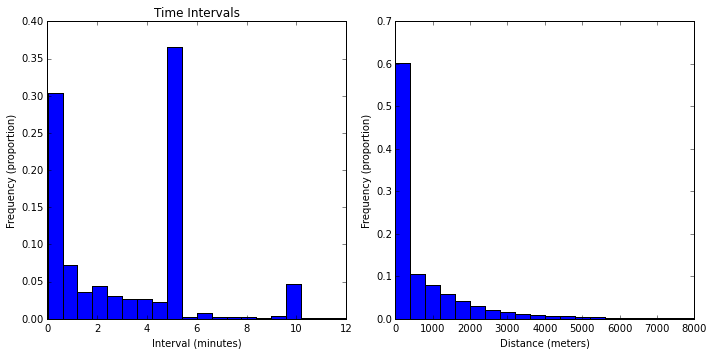

In [6]:
#%% Plotting: Time -- plots a histogram time intervals with 
#                     proportions summing to 1
print "Plotting time intervals..."
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
#fig = plt.figure(figsize = (8,4))
#fig.set_figure_width(6)
axes[0].set_xlabel('Interval (minutes)')
axes[0].set_ylabel('Frequency (proportion)')
axes[0].set_title('Time Intervals')

hist, bins = np.histogram(time_intervals[(time_intervals > 0) & \
            (time_intervals < 12)].astype(np.ndarray), bins=20)
axes[0].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))

#% Plotting: Distance -- plots a normed histogram of distance intervals
#distances = pd.Series(distances)
distances.dropna(inplace=True)

#hist, bins = np.histogram(distances[(distances > 0) & \
#            (distances < 8000)].astype(np.ndarray), bins=20)
hist, bins = np.histogram(distances[(distances[0] < 8000) & \
                        (distances[0] > 0)][0].values, bins=20)

axes[1].bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]))
axes[1].set_xlabel('Distance (meters)')
axes[1].set_ylabel('Frequency (proportion)')

fig.tight_layout()

## Position density

The following two plots are two-dimensional histograms. 
Density is plotted as a function of latitude and longitude. 
Not surprisingly, the data mostly lie on major roads and highways. 

Plotting position density...


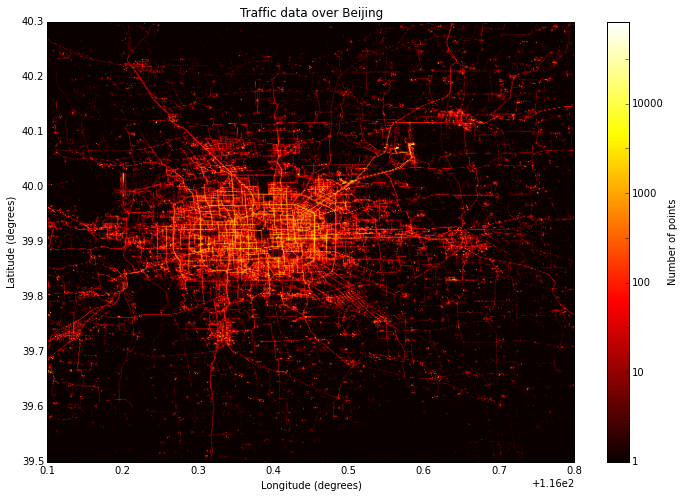

In [7]:
#%% Plot position density 
print "Plotting position density..."
xmin = 116.1
xmax = 116.8
ymin = 39.5
ymax = 40.3

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y,bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data over Beijing")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

## 5th Ring Road in Beijing

Cities in China use concentric ring roads centered on the city center. 
This plot provides a detailed look at the city. 

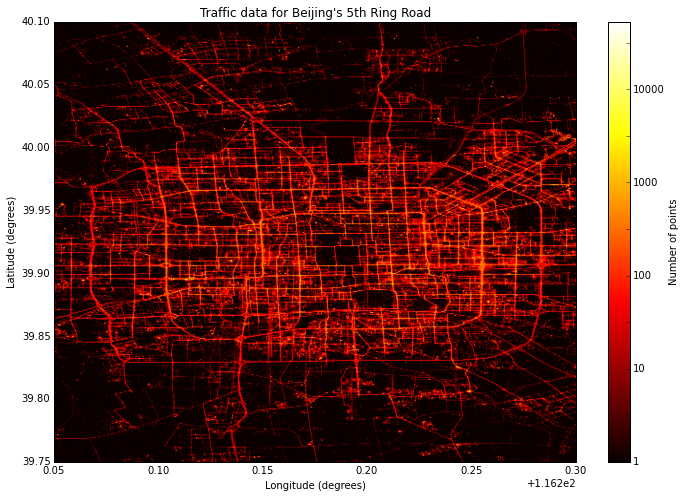

In [8]:
# Location details
xmin, xmax = 116.25, 116.5
ymin, ymax = 39.75, 40.1

window = data[(xmin < data.longitude) & (data.longitude < xmax) & \
            (ymin < data.latitude) & ( data.latitude < ymax)]

x = np.array(window.longitude)
y = np.array(window.latitude)

plt.figure(figsize = (10,7), dpi=150)
plt.hexbin(x,y, bins='log', gridsize=800, cmap=plt.cm.hot)   # black -> red > white
plt.axis([xmin, xmax, ymin, ymax])
plt.title("Traffic data for Beijing's 5th Ring Road")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')

cb = plt.colorbar(format=LogFormatterHB())
cb.set_label('Number of points')

plt.tight_layout()
plt.show()

Taxi data for Taxi ID: 1131
Start date and time: 2008-02-02 13:30:49
Duration: 0 days 00:52:34


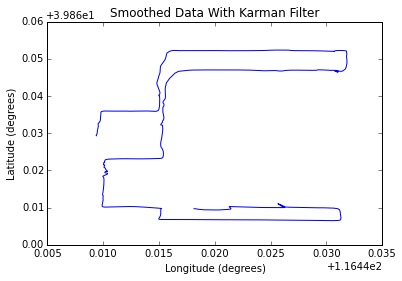

In [14]:
# Kalman Filter and plot results

# Select data for one taxi
one_taxi = data[data.taxi_id == data.taxi_id[100]]

# Choose how many data points to plot
end_index = 600

measurements = np.asarray([one_taxi.longitude, one_taxi.latitude])
measurements = measurements.T[0:end_index]
kf = KalmanFilter(initial_state_mean = measurements[0], \
           n_dim_obs=2, n_dim_state=2)

kf = kf.em(measurements)
#(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

#plt.plot(filtered_state_means.T[0],filtered_state_means.T[1])
plt.plot(smoothed_state_means.T[0],smoothed_state_means.T[1])
plt.title("Smoothed Data With Karman Filter")
plt.xlabel('Longitude (degrees)')
plt.ylabel('Latitude (degrees)')
print "Taxi data for Taxi ID: %d" % data.taxi_id[0]
print "Start date and time:", one_taxi.date_time[0]
print "Duration:", one_taxi.date_time[end_index] - one_taxi.date_time[0]
plt.figure()